The purpose of this notebook is to analyse the Cardiovascular Study Dataset and create a logistic regression model predicting the house price.

The structure is roughly as follows:

**1. Data loading and cleaning**

**2. Exploratory data analysis**

**3. Modelling**

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import KNNImputer
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### 1. Data loading and cleaning 

In [4]:
df = pd.read_csv("train.csv", index_col = 0)
df.shape

(3390, 16)

In [5]:
df.sample(10)

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
2271,44,2.0,M,YES,20.0,0.0,0,1,0,264.0,138.0,92.0,28.32,63.0,67.0,0
3170,44,1.0,M,YES,20.0,0.0,0,0,0,232.0,137.5,87.5,30.03,88.0,70.0,0
138,53,3.0,F,NO,0.0,0.0,0,1,0,238.0,172.5,91.0,24.16,112.0,NaN,0
1760,63,1.0,F,NO,0.0,1.0,0,1,0,281.0,135.0,83.0,24.91,63.0,68.0,0
1758,56,1.0,F,NO,0.0,0.0,0,0,0,254.0,106.0,65.0,24.08,75.0,NaN,0
2630,53,1.0,M,NO,0.0,0.0,0,1,0,202.0,140.5,90.0,25.82,85.0,74.0,0
771,44,2.0,M,NO,0.0,0.0,0,0,0,267.0,131.0,79.0,30.32,70.0,79.0,0
714,49,2.0,M,YES,5.0,0.0,0,0,0,260.0,111.0,70.0,24.24,75.0,87.0,0
452,48,3.0,F,NO,0.0,0.0,0,0,0,309.0,136.0,90.0,26.83,70.0,75.0,0


From the sample data I can see that there are some NaN values, so let's check that

In [7]:
df.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

Looking at the data, I've thought about several strategies to handle missing values in the dataset rather than discarding rows with missing data. The approach varies by variable type and missingness pattern:

## Numerical Variables:
- **cigsPerDay**: Used conditional imputation - 0 for non-smokers with missing values, and median of smokers' values for smokers with missing data
- **BMI, heartRate, totChol**: Applied median imputation as these are physiological measures with relatively few missing values
- **glucose**: Implemented KNN imputation due to higher missingness (~9%). This approach uses the 5 most similar records (based on age, BMI, blood pressure, etc.) to estimate missing glucose values, preserving relationships between variables

## Categorical/Binary Variables:
- **education**: Filled missing values with the mode (most common value)

       Some high school (1)
       high school/GED (2)
       some college/vocational school (3)
       college (4)
  
- **BPMeds**: Imputed with the mode as this is a binary indicator variable

## KNN Imputation Process:
For glucose and other numeric variables, I used scikit-learn's KNNImputer with k=5 neighbors. This method finds the 5 most similar records based on other variables and uses their average values to fill in missing data, which is more sophisticated than simple statistical imputation.

This approach allows me to retain all observations while minimizing bias that could be introduced by simpler imputation methods or by dropping records.

In [9]:
smokers_median = df[df['is_smoking'] == 'YES']['cigsPerDay'].median()
df['cigsPerDay'] = df.apply(
    lambda row: 0 if row['is_smoking'] == 'NO' and pd.isna(row['cigsPerDay']) 
    else (smokers_median if row['is_smoking'] == 'YES' and pd.isna(row['cigsPerDay']) 
    else row['cigsPerDay']), 
    axis=1
)
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].median())
df['totChol'] = df['totChol'].fillna(df['totChol'].median())
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])

# Just apply KNN imputation directly without creating the glucose_missing column
numeric_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

After the work with missing values, we can double-check that

In [11]:
df.isna().sum()

age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

### 2. Exploratory data analysis

Text(0.5, 1.0, 'Age Distribution')

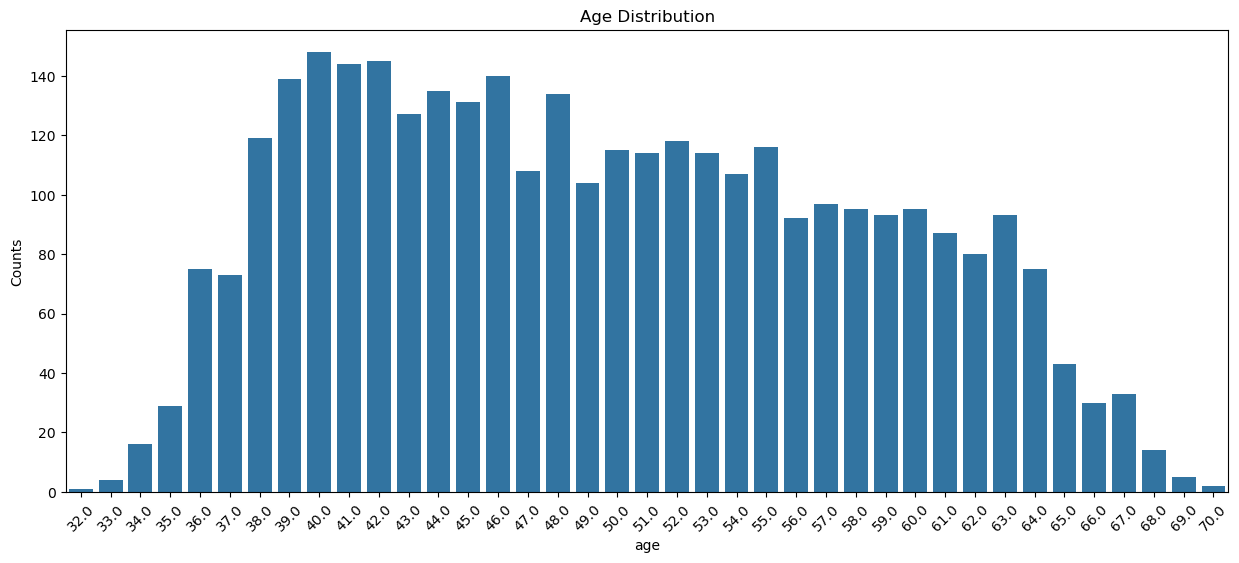

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
age_dis = df.groupby(['age'])['age'].count()
sns.barplot(x=age_dis.index, y=age_dis, ax=ax)
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title('Age Distribution')


The distribution is quite balanced and no outliers or significant results we cannot observe in order to react

Let's see, how many people in total has CHD risk and what is the Age distribution

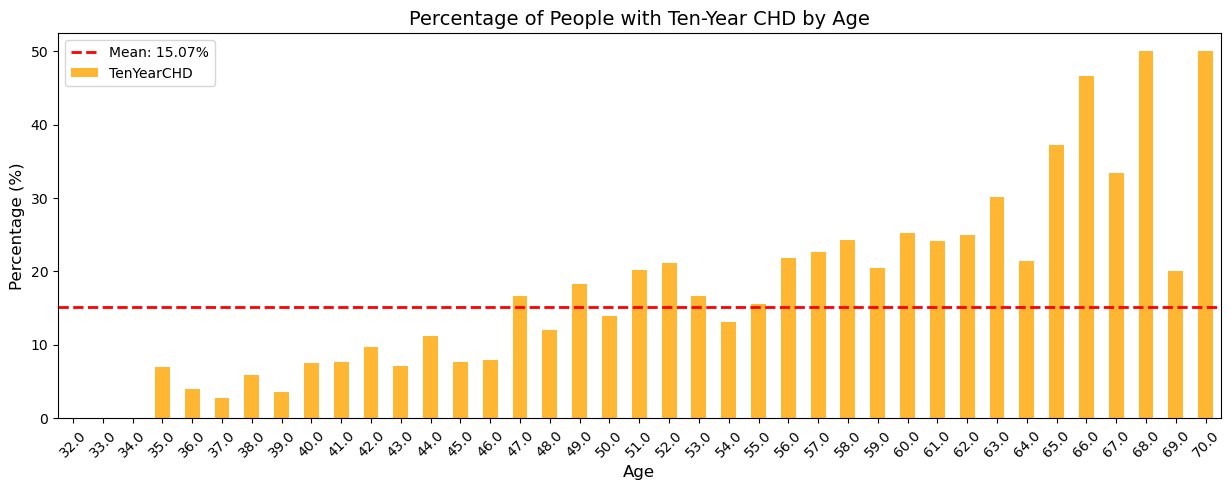

Total Count by CHD disease confirmations:
TenYearCHD
0    2879
1     511
Name: count, dtype: int64


In [15]:
percentage_data = df.groupby('age')['TenYearCHD'].mean() * 100

mean_percentage = df['TenYearCHD'].mean() * 100

plt.figure(figsize=(15, 5))
percentage_data.plot(kind='bar', color='orange', alpha=0.8)

plt.axhline(y=mean_percentage, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_percentage:.2f}%')

plt.title('Percentage of People with Ten-Year CHD by Age', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45) 
plt.legend()

plt.show()


print("Total Count by CHD disease confirmations:")
print(df['TenYearCHD'].value_counts())


There are around 15 percent people that have the risk of CHD. And from the graph we can clearly see that the CHD risk increases with the increase of age. However, the age is just a single variable that could have influence when predicting data and we should take into consideration as many figures as we can. 


Now let's look at the CHD risk distribution around different sex. 

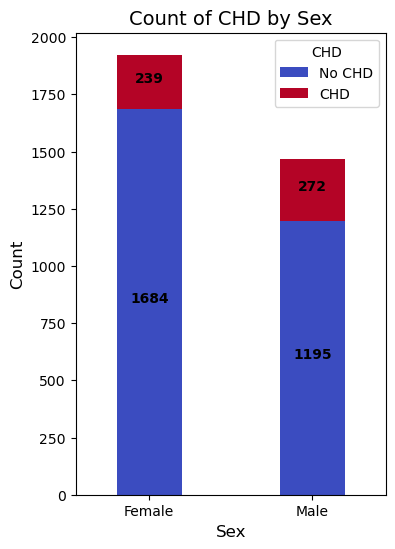

Total Count by Sex:
sex
F    1923
M    1467
dtype: int64

CHD Count by Sex:
TenYearCHD     0    1
sex                  
F           1684  239
M           1195  272

CHD Percentage by Sex
sex
F    12.43
M    18.54
Name: TenYearCHD, dtype: float64


In [17]:
sex_counts = df.groupby('sex').size()

chd_counts = df.groupby(['sex', 'TenYearCHD']).size().unstack()

fig, ax = plt.subplots(figsize=(4, 6))

chd_counts.plot(kind="bar", stacked=True, colormap="coolwarm", ax=ax, width=0.4)
    
ax.set_title('Count of CHD by Sex', fontsize=14)
ax.set_xlabel('Sex', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['Male' if x == 'M' else 'Female' for x in chd_counts.index], rotation=0)
ax.legend(["No CHD", "CHD"], title="CHD", loc="best")


for i, (idx, row) in enumerate(chd_counts.iterrows()):
    ax.text(i, row[0] / 2, f"{int(row[0])}", ha="center", color="black", fontweight="bold")
    ax.text(i, row[0] + row[1] / 2, f"{int(row[1])}", ha="center", color="black", fontweight="bold")

plt.show()

print("Total Count by Sex:")
print(sex_counts)

print("\nCHD Count by Sex:")
print(df.groupby(['sex', 'TenYearCHD']).size().unstack())

print("\nCHD Percentage by Sex")
print(df.groupby('sex')['TenYearCHD'].mean().round(4)*100)


Altough in this data sample we have more Females, we see that CHD risk is more common to Males. This could be intriguing factor when building the linear regression model.

Moving on, we have to look at Education and try to see what is the relation between education level and risk of CHD

Education vs CHD Cross-tabulation:
TenYearCHD     0    1   All
education                  
1.0         1209  269  1478
2.0          872  118   990
3.0          479   70   549
4.0          319   54   373
All         2879  511  3390

Percentage of CHD within each education level:
education
1.0    18.20
2.0    11.92
3.0    12.75
4.0    14.48
Name: 1, dtype: float64


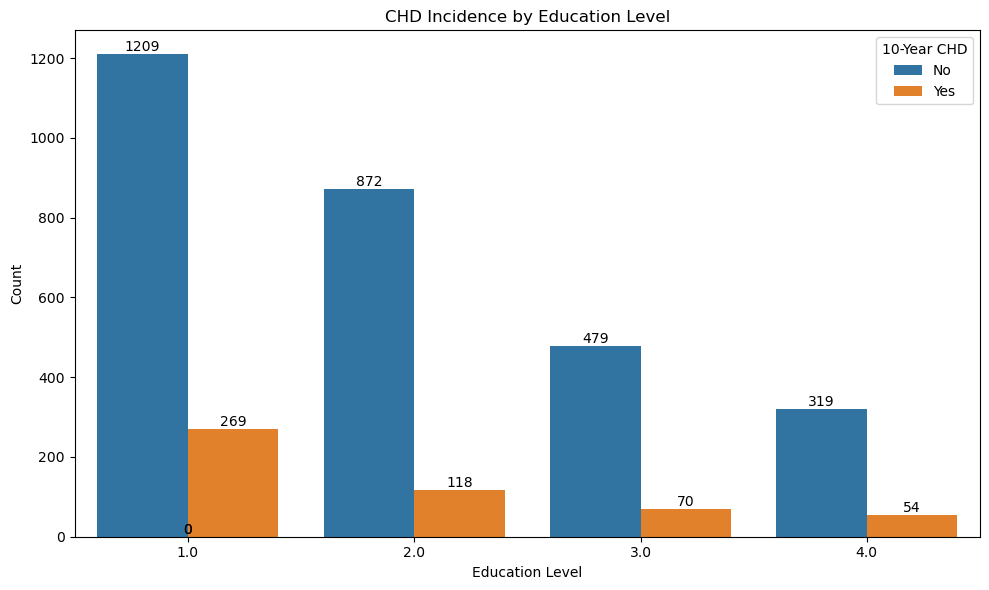

In [19]:
education_chd = pd.crosstab(df['education'], df['TenYearCHD'], margins=True)
print("Education vs CHD Cross-tabulation:")
print(education_chd)

education_pct = pd.crosstab(df['education'], df['TenYearCHD'], normalize='index') * 100
print("\nPercentage of CHD within each education level:")
print(education_pct[1].round(2))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education', hue='TenYearCHD')
plt.title('CHD Incidence by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='10-Year CHD', labels=['No', 'Yes'])

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width()/2., p.get_height()),
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()

Looking at the education and CHD risk distribution, we can conclude that, on average, people with high-school education has the highest CHD risk, although we have to take into consideration that high-school graduates, on average, tends to have bad habits that could be an answer to higher disease levels.

Now, let's look at Smoking status and its correlation with CHD risk. 

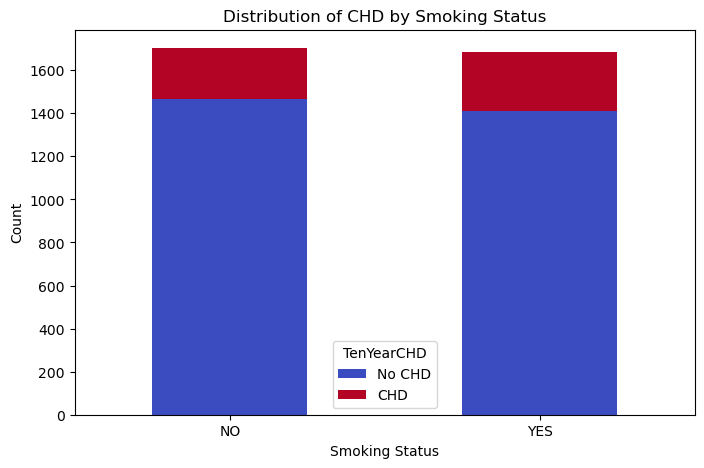

TenYearCHD     0    1
is_smoking           
NO          1467  236
YES         1412  275


In [21]:
smoking_chd_counts = df.groupby(['is_smoking', 'TenYearCHD']).size().unstack()

smoking_chd_counts.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='coolwarm')

plt.title('Distribution of CHD by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.legend(title='TenYearCHD', labels=['No CHD', 'CHD'])
plt.xticks(rotation=0) 
plt.show()

print(smoking_chd_counts)


There are no differences of CHD risk and smoking status. However, we have additional column about smoking intensity, which could provide some valuable insights. 

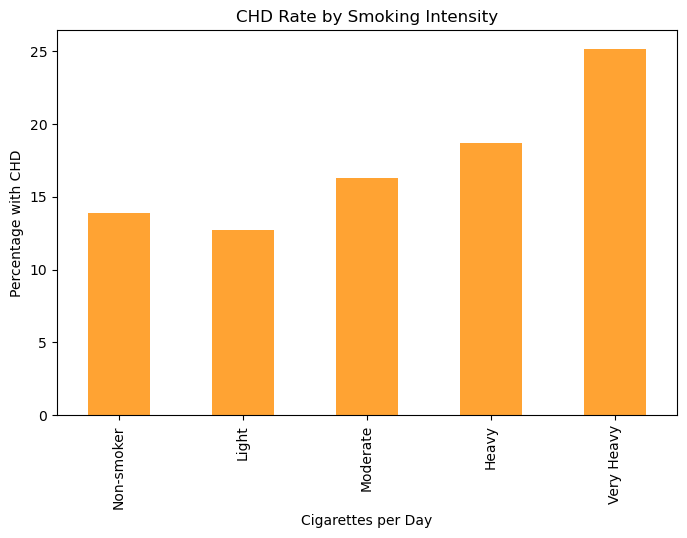

In [23]:
bins = [-0.1, 0, 10, 20, 30, 99]
labels = ['Non-smoker', 'Light', 'Moderate', 'Heavy', 'Very Heavy']
df['smoking_category'] = pd.cut(df['cigsPerDay'], bins=bins, labels=labels)

smoking_chd_rate = df.groupby('smoking_category', observed=False)['TenYearCHD'].mean() * 100

plt.figure(figsize=(8, 5))
smoking_chd_rate.plot(kind='bar', color='darkorange', alpha=0.8)
plt.title('CHD Rate by Smoking Intensity')
plt.xlabel('Cigarettes per Day')
plt.ylabel('Percentage with CHD')
plt.show()

The tendency is clear - the more person is smoking, the higher the chanches are for him to be at risk for CHD

Now we should look at historical health conditions that could have the correlation with the higher risk of CHD.

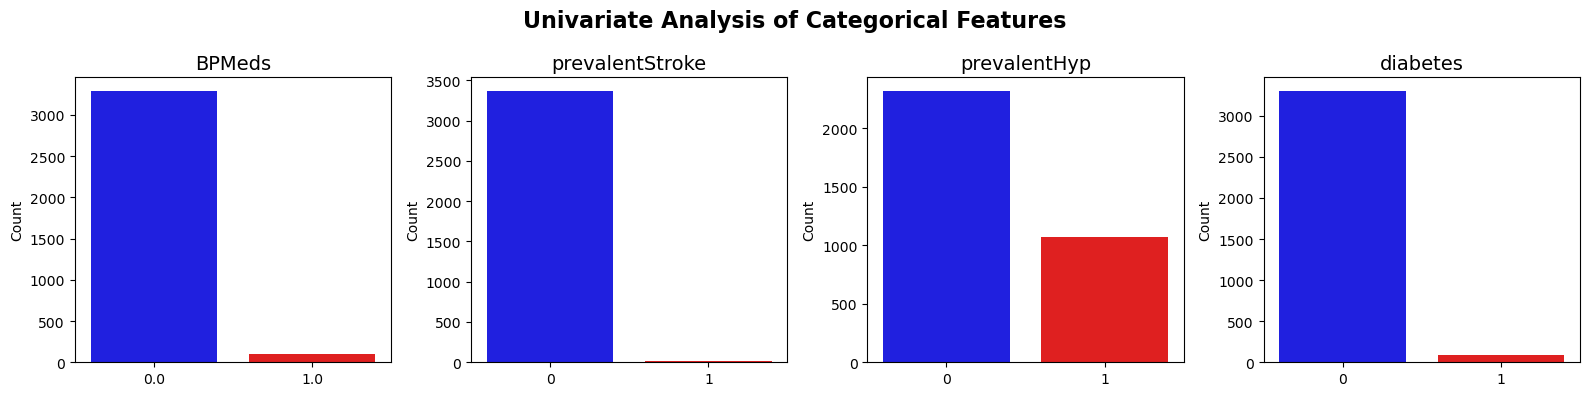

In [26]:
categorical_vars = ['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 

custom_palette = {0: 'blue', 1: 'red'}
for ax, var in zip(axes, categorical_vars):
    sns.countplot(data=df, x=var, ax=ax, hue=var, legend=False, palette=custom_palette)
    ax.set_title(var, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    palette=custom_palette

plt.suptitle("Univariate Analysis of Categorical Features", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


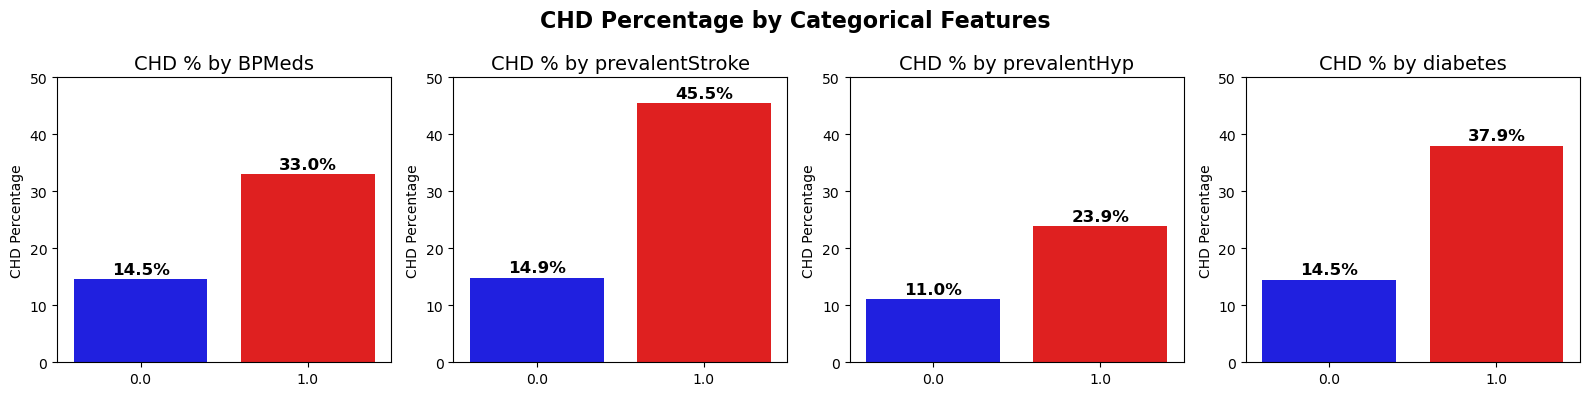

In [27]:
categorical_vars = ['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

chd_percentages = {}
for var in categorical_vars:
    chd_percentages[var] = df.groupby(var)['TenYearCHD'].mean() * 100

chd_df = pd.DataFrame(chd_percentages).T

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

custom_palette = {0: 'blue', 1: 'red'}

for ax, var in zip(axes, categorical_vars):
    sns.barplot(
        x=chd_df.loc[var].index, 
        y=chd_df.loc[var].values, 
        hue=chd_df.loc[var].index, 
        ax=ax, 
        palette=custom_palette, 
        dodge=False, 
        legend=False 
    )

    ax.set_title(f"CHD % by {var}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("CHD Percentage")
    ax.set_ylim(0, 50)

    for i, value in enumerate(chd_df.loc[var].values):
        ax.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=12, fontweight='bold')

plt.suptitle("CHD Percentage by Categorical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Among all historically confirmed diseases, it seems that each of them could contribute to higher risk of CHD. 

Nevertheless. it is equally important to look at current medical conditions when trying to see any patterns. We will see at the distribution and outliers of those numeric features. 

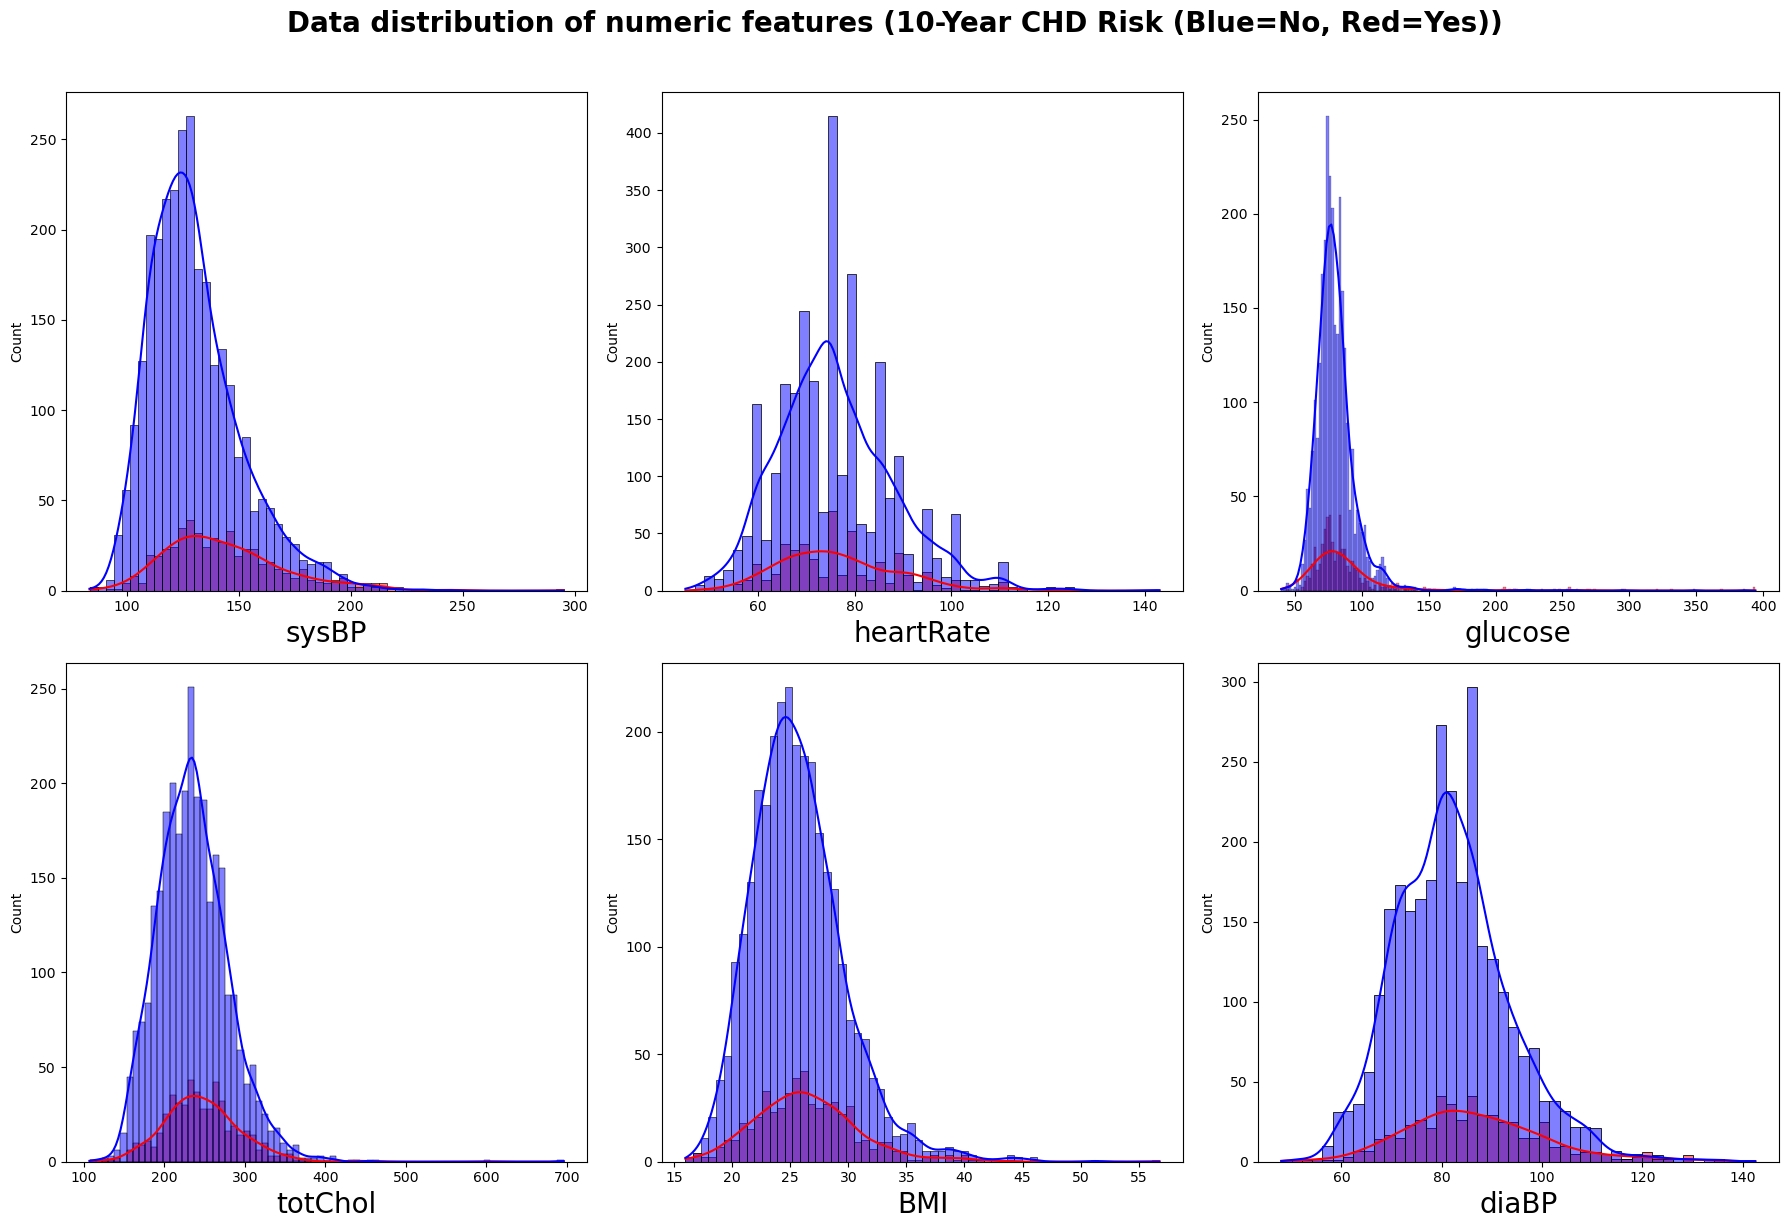

In [29]:
numeric_features = ['sysBP', 'heartRate', 'glucose', 'totChol', 'BMI', 'diaBP']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.suptitle('Data distribution of numeric features (10-Year CHD Risk (Blue=No, Red=Yes))', 
             fontsize=20, fontweight='bold', y=1.02)

for ax, var in zip(axes.flat, numeric_features):  
    sns.histplot(data=df, x=var, hue='TenYearCHD', kde=True, palette=['blue', 'red'], ax=ax, legend=False)
    ax.set_xlabel(var, fontsize=20) 
    ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()


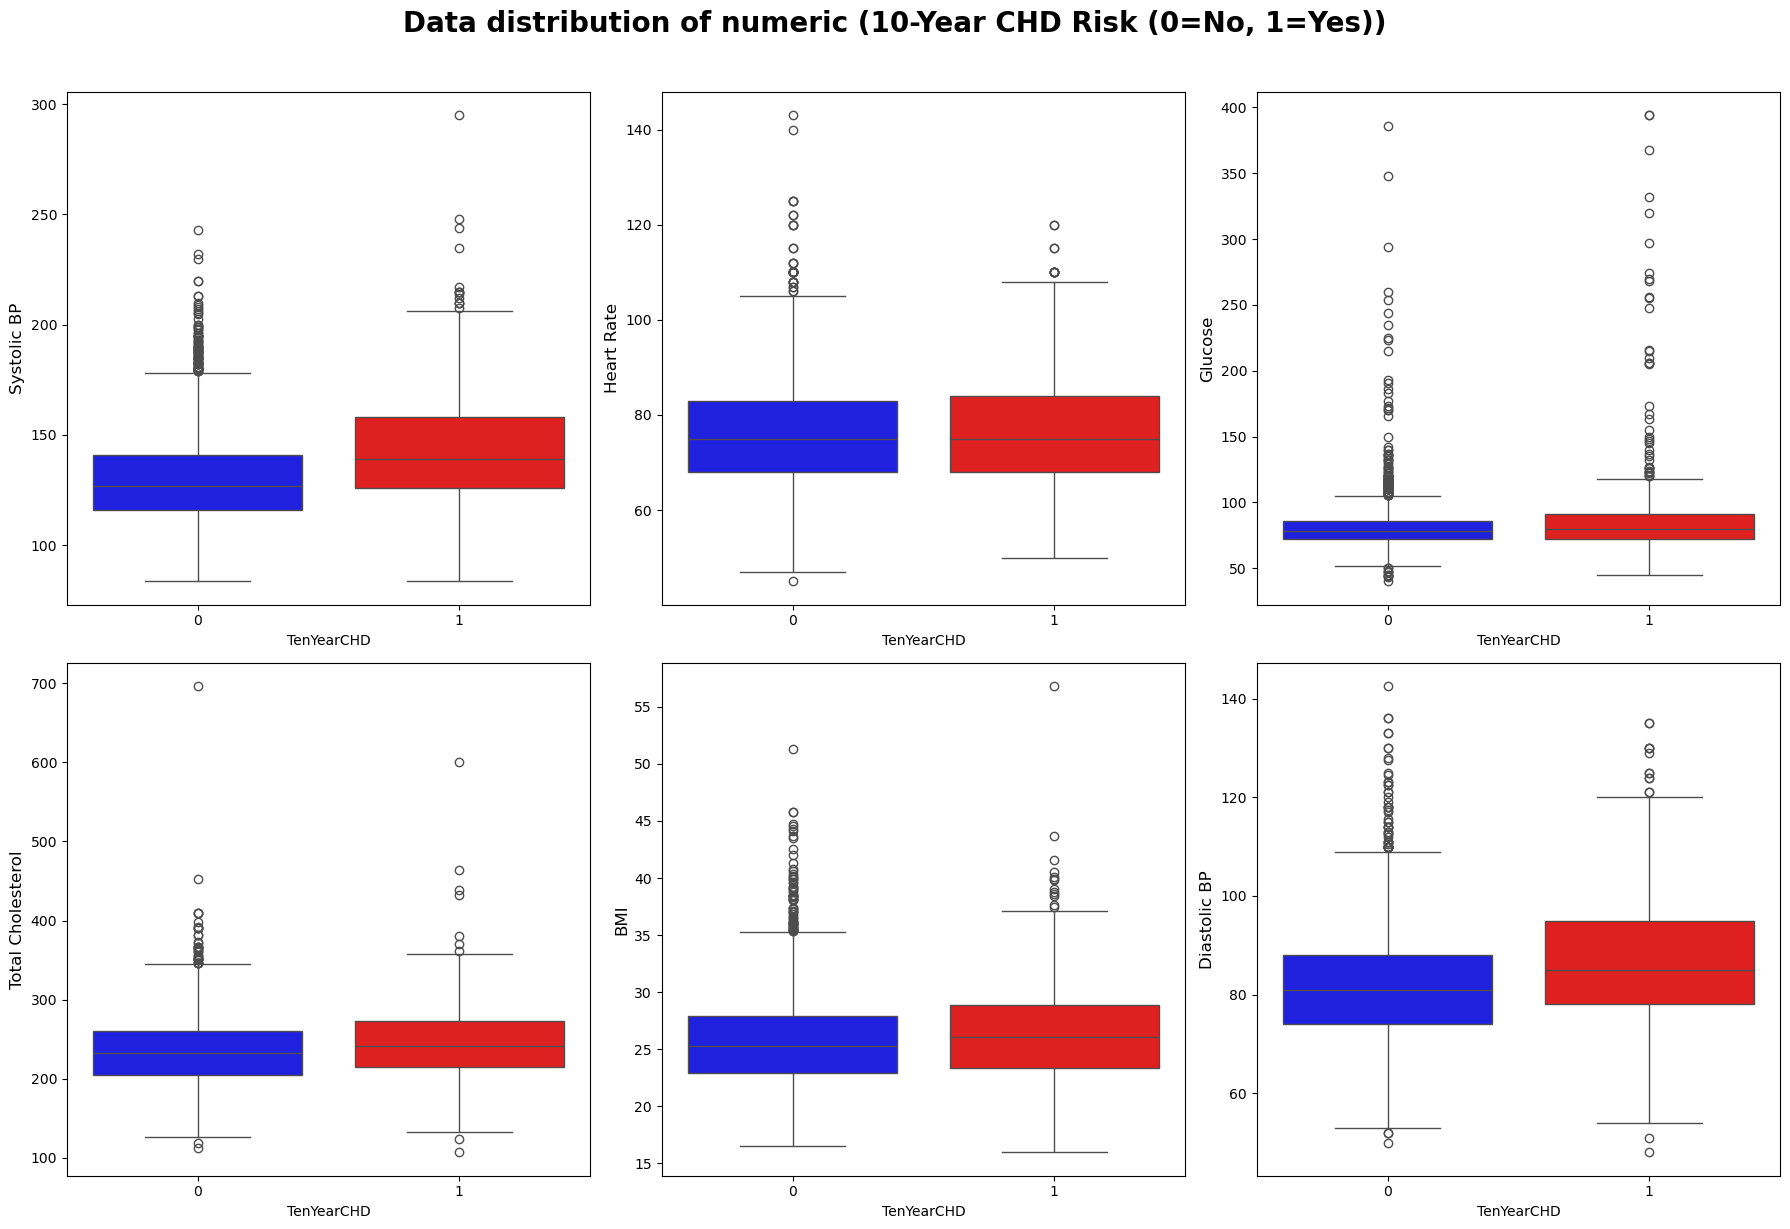

In [30]:
numeric_features = ['sysBP', 'heartRate', 'glucose', 'totChol', 'BMI', 'diaBP']
titles = ['Systolic BP', 'Heart Rate', 'Glucose', 'Total Cholesterol', 'BMI', 'Diastolic BP']

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
plt.suptitle('Data distribution of numeric (10-Year CHD Risk (0=No, 1=Yes))', fontsize=20, fontweight='bold', y=1.02)
for ax, var, title in zip(axes.flat, numeric_features, titles):
    sns.boxplot(data=df, x='TenYearCHD', y=var, hue='TenYearCHD', ax=ax, palette=['blue', 'red'], legend=False)
    ax.set_ylabel(title, fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


We see many outliers, so we should intervene into the dataset. We will use Clipping method.

Clipping Method: In this method, we set a cap on our outliers data, which means that if a value is higher than or lower than a certain threshold, all values will be considered outliers. This method replaces values that fall outside of a specified range with either the minimum or maximum value within that range.

It is also called Winsorising method - I've taken this from https://theeffectbook.net/ch-StatisticalAdjustment.html#getting-fancier-with-regression


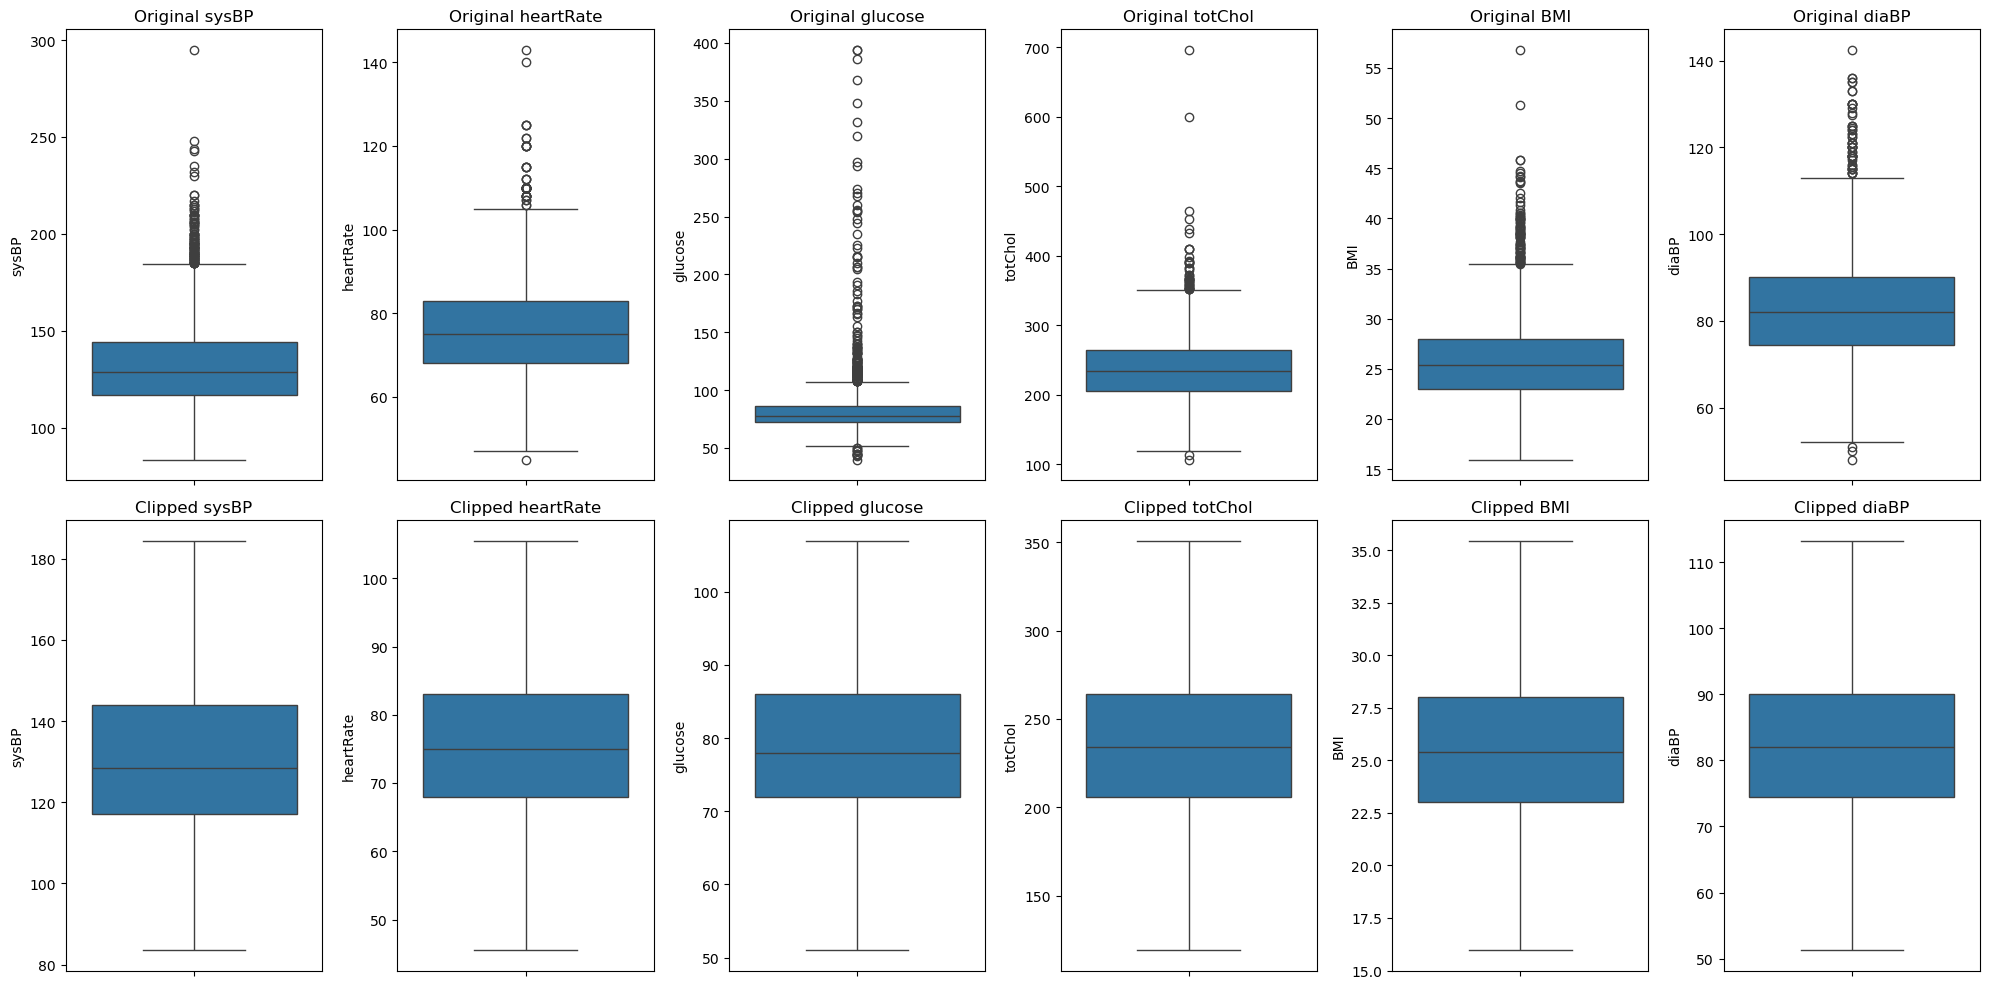

In [32]:
def clip_outliers(df, columns_to_clip):
    df_clipped = df.copy()
    
    for col in columns_to_clip:
        q1 = df_clipped[col].quantile(0.25)
        q3 = df_clipped[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_clipped[col] = df_clipped[col].clip(lower_bound, upper_bound)
    
    return df_clipped

columns_to_clip = ['sysBP', 'heartRate', 'glucose', 'totChol', 'BMI', 'diaBP']

df_clipped = clip_outliers(df, columns_to_clip)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_clip):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Original {col}')

for i, col in enumerate(columns_to_clip):
    sns.boxplot(y=df_clipped[col], ax=axes[i+6])
    axes[i+6].set_title(f'Clipped {col}')

plt.tight_layout()
plt.show()

In [33]:
df['sex'] = df['sex'].replace({'M':1, 'F':0})
df['is_smoking'] = df['is_smoking'].replace({'YES': 1, 'NO': 0}).infer_objects(copy=False)

C:\Users\Kipras\AppData\Local\Temp\ipykernel_3240\1146450873.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'M':1, 'F':0})
C:\Users\Kipras\AppData\Local\Temp\ipykernel_3240\1146450873.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_smoking'] = df['is_smoking'].replace({'YES': 1, 'NO': 0}).infer_objects(copy=False)


In [34]:
df.dtypes

age                  float64
education            float64
sex                    int64
is_smoking             int64
cigsPerDay           float64
BPMeds               float64
prevalentStroke        int64
prevalentHyp           int64
diabetes               int64
totChol              float64
sysBP                float64
diaBP                float64
BMI                  float64
heartRate            float64
glucose              float64
TenYearCHD             int64
smoking_category    category
dtype: object

Those binary variables shall be reconverted into the categorical columns as type str

In [36]:
Converted_variables = ['sex','is_smoking','prevalentStroke','prevalentHyp','diabetes','BPMeds']
df[Converted_variables] = df[Converted_variables].astype(str)
df.dtypes

age                  float64
education            float64
sex                   object
is_smoking            object
cigsPerDay           float64
BPMeds                object
prevalentStroke       object
prevalentHyp          object
diabetes              object
totChol              float64
sysBP                float64
diaBP                float64
BMI                  float64
heartRate            float64
glucose              float64
TenYearCHD             int64
smoking_category    category
dtype: object

In [37]:
df = df.drop(columns=['is_smoking', 'smoking_category'])
df.head(5)

,age,education,sex,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,
0,64.0,2.0,0,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36.0,4.0,1,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46.0,1.0,0,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50.0,1.0,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64.0,1.0,0,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


Also, Taken from Cardiovascular_Notebook_Navneet_Keshri.ipynb

The highest number in your systolic blood pressure reading.
The lowest number on your diastolic blood pressure readings.
Pulse Pressure is the sum of the top number (systolic) and the bottom number (diastolic). For instance, a pulse pressure of 40 is considered to be healthy if the resting blood pressure is 120/80 millimeters of mercury (mm Hg). A pulse pressure greater than 40 mm Hg is typically considered unhealthy.

The risk of a heart event, such as a heart attack or stroke, can be predicted by measuring pulse pressure. High pulse pressure, especially in older people, is considered a risk factor for cardiovascular disease.

In [39]:
# adding new column PulsePressure 
df['pulse_pressure'] = df['sysBP'] - df['diaBP']

# dropping the sysBP and diaBP columns
df.drop(columns=['sysBP', 'diaBP'], inplace=True)


After preparing all the variables, we can look at the correlation Coefficient.


<Axes: >

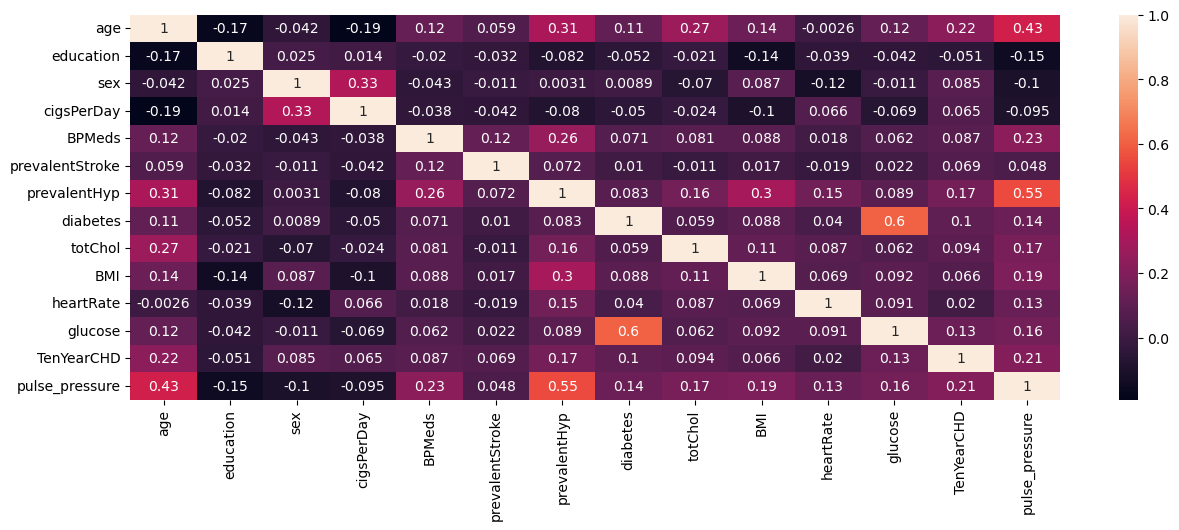

In [41]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), annot=True)    

After looking at this correlation heatmap, I've decided to build a linnear regression model with 8 independent variables:

**-age**  

-**sex** 

-**BPMeds** 

-**prevalentStroke** 

**-totChol** 

-**glucose** 

-**pulse_pressure** 
    
All those independent variables have higher than 0,07 correlation coefficient

Also, I need to implement some additional libaries in order to succesfully run a logistic regression. 

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In this section, I define the predictor variables (X) and the target variable (y). The numerical features include age, cholesterol level, pulse pressure, and glucose, while the categorical features include sex, blood pressure medication usage (BPMeds), and history of stroke (prevalentStroke). These features will be used to train the model for predicting the 10-year risk of coronary heart disease (TenYearCHD).

In [49]:
numerical_feats = ["age", "totChol", "pulse_pressure", "glucose"]
categorical_feats = ["sex", "BPMeds","prevalentStroke"]

y = df["TenYearCHD"]
X = df[categorical_feats + numerical_feats]

This line prints the class distribution of the target variable (y) before applying SMOTE. It helps to visualize the class imbalance in the dataset, showing how many instances belong to each class before oversampling.

In [51]:
print(f'Before SMOTE: {Counter(y)}')

Before SMOTE: Counter({0: 2879, 1: 511})


First, I split the dataset into training (X_train, y_train) and testing (X_test, y_test) sets using an 80-20 split while preserving class proportions with stratification. Then, I apply SMOTE (Synthetic Minority Oversampling Technique) only to the training data to balance the class distribution by generating synthetic samples for the minority class. Finally, I print the new class distribution after SMOTE to confirm that the training data is balanced.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE ONLY to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f'After SMOTE in training data: {Counter(y_train_resampled)}')

After SMOTE in training data: Counter({0: 2303, 1: 2303})


This section defines a ColumnTransformer to preprocess the data before feeding it into the model. Numerical features (numerical_feats) are standardized using StandardScaler(), which scales them to have a mean of 0 and a standard deviation of 1. Categorical features (categorical_feats) are encoded using OrdinalEncoder(), which converts categorical values into numerical format. The handle_unknown='use_encoded_value', unknown_value=-1 parameter ensures that any unseen categories in the test set are encoded as -1 instead of causing an error.

In [65]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_feats),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
         , categorical_feats)
    ])

Now I'll create a Pipeline that combines preprocessing and classification
The Pipeline ensures that preprocessing and model training are applied sequentially:
1. 'preprocessor' step applies the ColumnTransformer to scale numerical and encode categorical features
2. 'classifier' step uses Logistic Regression with balanced class weights
    - class_weight='balanced' adjusts weights inversely proportional to class frequencies
    - random_state=42 ensures reproducibility of the model training

In [67]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])
# Fit the model on SMOTE-resampled training data
model.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'totChol',
                                                   'pulse_pressure',
                                                   'glucose']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sex', 'BPMeds',
                                                   'prevalentStroke'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42))])

Now I will convert model predictions to binary classification
This step involves two key operations:
1. model.predict() generates probability predictions for each class
2. A custom threshold (0.3 in this case) is used to convert probabilities to binary predictions
- Lowering the threshold from the default 0.5 can increase sensitivity (recall) 
    for the positive class, which is often useful in scenarios like:
    - Medical diagnoses
    - Fraud detection
    - Rare event prediction
- The threshold can be adjusted based on:
   - Business requirements
   - ROC curve analysis
   - Precision-recall trade-offs
 - .astype(int) converts True/False to 1/0 for classification metrics

In [69]:
# Convert predicted values to binary classification (assuming binary classification problem)
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.3).astype(int)  # Adjust threshold if necessary

# Generate classification report
print(classification_report(y_test, y_pred_class))


              precision    recall  f1-score   support

           0       0.89      0.86      0.88       576
           1       0.34      0.40      0.37       102

    accuracy                           0.79       678
   macro avg       0.61      0.63      0.62       678
weighted avg       0.81      0.79      0.80       678



The model achieves an **overall accuracy of 79%**, but the class-wise performance reveals an imbalance in prediction quality.  

- **Class 0 (No Cardiovascular Disease)**:  
  - Precision: **89%**  
  - Recall: **86%**  
  - F1-score: **88%**  
- **Class 1 (Cardiovascular Disease)**:  
  - Precision: **34%**  
  - Recall: **40%**  
  - F1-score: **37%**  

The **macro average F1-score (0.62)** suggests a notable disparity between the two classes, indicating the model favors the majority class (Class 0). The **weighted average F1-score (0.80)** remains relatively high due to Class 0's dominance in the dataset.  


I should evaluate model performance using Receiver Operating Characteristic (ROC) curve
ROC curve illustrates the diagnostic ability of a binary classifier system
 - X-axis (False Positive Rate): Proportion of negative instances incorrectly classified
 - Y-axis (True Positive Rate/Recall): Proportion of positive instances correctly classified
 - AUC (Area Under Curve) measures overall model discrimination:
   * AUC = 0.5 suggests no better than random guessing
   * AUC = 1.0 indicates perfect classification
   * Higher AUC values represent better model performance

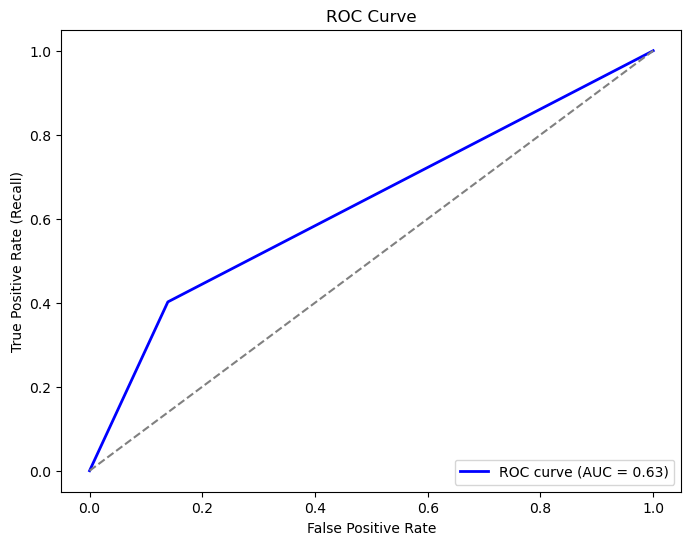

AUC-ROC Score: 0.6315


In [71]:
y_pred_prob = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

#### Key Observations:  
- The **AUC-ROC score is 0.63**, indicating that the model has **limited discriminatory power**.  
- A **random classifier** would achieve an **AUC of 0.50**, meaning the model is only slightly better than random guessing.  
- The **ROC curve (blue line)** does not show a strong separation from the diagonal baseline (**gray dashed line**), which represents a random model.  

Let's inspect several predictions.

In [73]:
y_pred = model.predict(X_test)
df_test = X_test.copy()
df_test["TenYearCHD_pred"] = y_pred
df_test["TenYearCHD_actual"] = y_test
df_test.sample(5)

,sex,BPMeds,prevalentStroke,age,totChol,pulse_pressure,glucose,TenYearCHD_pred,TenYearCHD_actual
id,,,,,,,,,
926,0,0.0,0,42.0,197.0,43.0,63.0,0,0
1348,1,0.0,0,56.0,194.0,44.0,73.0,0,0
2364,0,0.0,0,48.0,193.0,51.0,90.0,0,0
2912,0,0.0,0,42.0,274.0,45.0,80.4,0,0
2904,1,0.0,0,40.0,203.0,42.5,72.0,0,0


### Improvements

1. Feature Engineering – Consider incorporating additional derived features, such as BMI (Body Mass Index), cholesterol ratios, or interaction terms between key variables. More informative features can help the model capture hidden patterns.

2. Handling Missing Data More Effectively – While imputation is already used, exploring advanced techniques like multiple imputation or deep-learning-based imputers might improve data quality.

3. Model Selection and Tuning – Logistic regression is a good starting point, but trying more complex models like Random Forest, XGBoost, or Neural Networks could boost predictive performance. Fine-tuning hyperparameters with GridSearch or Bayesian optimization can also help.

4. External Data Sources – Integrating additional health-related datasets (e.g., demographic health statistics, lifestyle factors, or genetic predispositions) might improve the model’s robustness.

### Conclusion
In this study, we analyzed a cardiovascular dataset and developed a predictive model to assess the likelihood of cardiovascular disease. We followed a structured approach, including data preprocessing, exploratory data analysis, and model training. While our initial model provided insightful results, there is room for improvement in terms of predictive performance.

Key takeaways from this study include:

The importance of handling missing data effectively to ensure model robustness.
The impact of feature selection and engineering in enhancing model performance.
The potential for exploring alternative machine learning models beyond linear regression to better capture non-linear patterns in the data.
Future improvements could involve trying more advanced models, refining feature selection, and incorporating additional relevant health-related data. These enhancements could further boost metrics such as F1-score and ROC-AUC, making the predictions more reliable and actionable.